# Lecture 13 - De novo Molecule Generation

```{contents}
:local:
:depth: 1
```

## Learning goals

- Connect **unsupervised learning** ideas to **molecular generation**.
- Explain what an **encoder** and a **decoder** are.
- Build a tiny **Autoencoder (AE)** for SMILES and discuss its limits for generation.
- Understand the **Variational Autoencoder (VAE)** idea and why it helps sampling.
- Train a small **VAE on SMILES** and generate new molecules.
- Inspect what **encode** outputs look like and how sampling works in latent space.

[![Colab](https://img.shields.io/badge/Open-Colab-orange)]()

---

## 1. Setup and data

We will use two small datasets.

- A subset of **C-H oxidation** molecules (~500). Good for a warm up AE demo.
- A small **QM9**-like set of ~1000 SMILES for a VAE practice run.

If a download fails, the notebook will create a tiny fallback set so you can still run the lesson.

In [1]:
# Core
import os, io, sys, math, random, json, textwrap, itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ML (CPU friendly)
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# Cheminformatics
try:
    from rdkit import Chem
    from rdkit.Chem import Descriptors, Crippen, rdMolDescriptors, Draw
    RD = True
except Exception:
    RD = False
    print("RDKit not found. Please install rdkit for full functionality.")

We load the C-H oxidation dataset from the same source used in earlier lectures and show a few rows.

In [2]:
# C-H oxidation dataset
try:
    url_ch = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/C_H_oxidation_dataset.csv"
    df_ch = pd.read_csv(url_ch)
    # some datasets have text columns; we only keep what we need
    df_ch = df_ch.rename(columns={c:c.strip() for c in df_ch.columns})
    df_ch = df_ch.dropna(subset=["SMILES"]).reset_index(drop=True)
    df_ch_small = df_ch.sample(n=min(500, len(df_ch)), random_state=0).reset_index(drop=True)
except Exception as e:
    print("C-H dataset download failed, making a tiny fallback set:", e)
    # fallback: a handful of small hydrocarbons and heterocycles
    smiles_fallback = [
        "CC", "CCC", "CCCC", "c1ccccc1", "OCCO", "CCO", "CCN", "CCCl", "CCBr",
        "CC(=O)O", "C1CCCCC1", "c1ccncc1", "CCOC", "CCS", "CCF", "C=C", "C#N"
    ] * 40
    df_ch_small = pd.DataFrame({"SMILES": smiles_fallback[:500], "Compound Name": [f"M{i}" for i in range(500)]})

df_ch_small.head(3)

,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site
0,Isobutylbenzene,538-92-2,CC(C)Cc1ccccc1,0.021527,6.26,toxic,89.8,1,4
1,3-methylquinoline,612-58-8,Cc1cnc2ccccc2c1,0.046610,5.77,toxic,90.8,1,1
2,methyl 3-hydroxythiophene-2-carboxylate,6/9/5118,COC(=O)c1sccc1O,0.135246,5.90,non_toxic,78.4,-1,-1


Next we try to load 1k SMILES for a QM9 mini set. If it fails, we synthesize a small set by perturbing simple scaffolds.

In [3]:
def make_qm9_fallback(n=1000):
    base = ["CCO", "CCN", "CCC", "C=O", "COC", "c1ccccc1", "CCCl", "CC=O", "OCCO", "CC#N"]
    out = []
    for i in range(n):
        s = random.choice(base)
        # simple random concat or methyl add
        if random.random() < 0.5:
            s = "C" + s
        if random.random() < 0.3:
            s = s + "C"
        out.append(s)
    return pd.DataFrame({"SMILES": out})

try:
    url_qm = "https://raw.githubusercontent.com/zzhenglab/ai4chem/main/book/_data/qm9_1k.csv"
    df_qm9 = pd.read_csv(url_qm)
    df_qm9 = df_qm9.dropna(subset=["SMILES"]).reset_index(drop=True)
    if len(df_qm9) > 1000:
        df_qm9 = df_qm9.sample(1000, random_state=0).reset_index(drop=True)
except Exception as e:
    print("QM9 mini download failed, making fallback set:", e)
    df_qm9 = make_qm9_fallback(1000)

df_qm9.head(3)

QM9 mini download failed, making fallback set: HTTP Error 404: Not Found


,SMILES
0,CCCN
1,CCNC
2,Cc1ccccc1


We will need a tiny tokenizer for SMILES. For beginners, we use **character level** to keep it simple.

In [4]:
def build_charset(smiles_list, extra_tokens=("<pad>", "<bos>", "<eos>", "<unk>")):
    chars = set()
    for s in smiles_list:
        chars.update(list(s))
    vocab = list(sorted(chars))
    vocab = list(extra_tokens) + vocab
    stoi = {c:i for i,c in enumerate(vocab)}
    itos = {i:c for c,i in stoi.items()}
    return vocab, stoi, itos

def encode_smiles(s, stoi, max_len):
    ids = [stoi.get("<bos>")]
    for ch in s:
        ids.append(stoi.get(ch, stoi["<unk>"]))
    ids.append(stoi.get("<eos>"))
    # pad or truncate
    ids = ids[:max_len]
    ids += [stoi["<pad>"]] * (max_len - len(ids))
    return np.array(ids, dtype=np.int64)

def decode_ids(ids, itos):
    toks = []
    for i in ids:
        ch = itos[int(i)]
        if ch in ("<pad>", "<bos>"): 
            continue
        if ch == "<eos>":
            break
        toks.append(ch)
    return "".join(toks)

**Exercise A1**

1) Print the vocabulary size for the C-H subset.  
2) Change `max_len` to a smaller value and see what happens to truncation count.  
3) Add a new token to the vocabulary manually and reprint size.

```python
# TO DO
```

We now build tokenizers for both datasets and show an example of encode and decode.

In [5]:
ch_smiles = df_ch_small["SMILES"].astype(str).tolist()
qm_smiles = df_qm9["SMILES"].astype(str).tolist()

vocab_ch, stoi_ch, itos_ch = build_charset(ch_smiles)
vocab_qm, stoi_qm, itos_qm = build_charset(qm_smiles)

max_len_ch = min(64, max(len(s)+2 for s in ch_smiles))  # +2 for <bos>, <eos>
max_len_qm = min(64, max(len(s)+2 for s in qm_smiles))

print("C-H vocab size:", len(vocab_ch), "max_len:", max_len_ch)
print("QM9 vocab size:", len(vocab_qm), "max_len:", max_len_qm)

# demo
demo = ch_smiles[0]
ids = encode_smiles(demo, stoi_ch, max_len_ch)
print("Encoded shape:", ids.shape, "first 12 ids:", ids[:12])
print("Decoded:", decode_ids(ids, itos_ch))

C-H vocab size: 37 max_len: 64
QM9 vocab size: 12 max_len: 12
Encoded shape: (64,) first 12 ids: [ 1 19 19  5 19  6 19 30 10 30 30 30]
Decoded: CC(C)Cc1ccccc1


---

## 2. Encoder and decoder by example

We start with minimal building blocks: an **embedding** for tokens, a small **GRU** encoder to get a single vector, and a **GRU** decoder that tries to reconstruct the input. This is the plain **Autoencoder (AE)**.

Concepts:

- **Encoder** maps tokens to a latent vector: $z = f_\phi(x)$.
- **Decoder** maps the latent vector back to tokens: $\hat x = g_\theta(z)$.
- Training uses **reconstruction loss**. For sequences we use token cross-entropy.

In [6]:
class AE(nn.Module):
    def __init__(self, vocab_size, emb_dim=64, hid=128):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.encoder = nn.GRU(emb_dim, hid, batch_first=True)
        self.decoder = nn.GRU(emb_dim + hid, hid, batch_first=True)
        self.out = nn.Linear(hid, vocab_size)
        self.hid = hid

    def forward(self, x):
        # x: [B, T]
        emb = self.emb(x)                      # [B, T, E]
        _, h = self.encoder(emb)               # h: [1, B, H]
        h = h.squeeze(0)                       # [B, H]
        # teacher forcing: feed <bos> + previous target tokens during training
        # Build decoder input: concat token embedding with repeated h
        bos = x[:, :1]                         # first token is <bos>
        dec_in_tokens = torch.cat([bos, x[:, :-1]], dim=1)  # shift right
        dec_emb = self.emb(dec_in_tokens)      # [B, T, E]
        h_rep = h.unsqueeze(1).repeat(1, x.size(1), 1)   # [B, T, H]
        dec_cat = torch.cat([dec_emb, h_rep], dim=2)     # [B, T, E+H]
        dec_out, _ = self.decoder(dec_cat)
        logits = self.out(dec_out)             # [B, T, V]
        return logits, h                       # return tokens logits and latent

    def encode(self, x):
        emb = self.emb(x)
        _, h = self.encoder(emb)
        return h.squeeze(0)                    # [B, H]

    def decode_greedy(self, z, stoi, itos, max_len=64):
        # z: [B, H]
        B = z.size(0)
        cur = torch.full((B, 1), stoi["<bos>"], dtype=torch.long, device=z.device)
        outs = []
        h = None
        for _ in range(max_len):
            emb = self.emb(cur)                 # [B, 1, E]
            zrep = z.unsqueeze(1)               # [B, 1, H]
            dec_cat = torch.cat([emb, zrep], dim=2)
            dec_out, h = self.decoder(dec_cat, h)
            logits = self.out(dec_out[:, -1, :])        # [B, V]
            nxt = torch.argmax(logits, dim=-1, keepdim=True)  # [B, 1]
            outs.append(nxt)
            cur = nxt
            if int(nxt[0,0].item()) == stoi["<eos>"]:
                break
        outs = torch.cat(outs, dim=1)  # [B, T']
        return outs

Let us build a tiny dataset class and a single batch to inspect shapes. This helps students see what goes into the network.

In [7]:
class SmilesDataset(Dataset):
    def __init__(self, smiles, stoi, max_len):
        self.smiles = smiles
        self.stoi = stoi
        self.max_len = max_len

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        s = self.smiles[idx]
        x = encode_smiles(s, self.stoi, self.max_len)
        return torch.from_numpy(x)

# small C-H dataset for AE
train_smiles_ae = ch_smiles
ds_ae = SmilesDataset(train_smiles_ae, stoi_ch, max_len_ch)
dl_ae = DataLoader(ds_ae, batch_size=64, shuffle=True)

batch = next(iter(dl_ae))
batch.shape, batch[0][:12]

(torch.Size([64, 64]),
 tensor([ 1, 19, 17, 19, 19, 19, 19, 19, 19, 19, 19, 19]))

**What does encode really look like?** We pass one sequence into the encoder and print the latent vector.

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ae = AE(vocab_size=len(vocab_ch), emb_dim=64, hid=128).to(device)

x1 = batch[:1].to(device)         # one sample
with torch.no_grad():
    z1 = ae.encode(x1)            # [1, 128]
print("Latent vector shape:", tuple(z1.shape))
print("First 8 numbers:", z1[0, :8].cpu().numpy().round(3))

Latent vector shape: (1, 128)
First 8 numbers: [-0.045  0.084  0.023 -0.006 -0.034 -0.03  -0.104 -0.035]


**Exercise A2**

1) Change `hid` from 128 to 32 and print the new latent vector shape.  
2) Inspect the first 8 numbers again. Are they larger or smaller on average  
3) Try `emb_dim` 32 vs 128 and see if the loss in the next section changes faster.

```python
# TO DO
```

---

## 3. Training a simple AE on C-H subset

We keep the training loop short to fit in class time. The goal is to reconstruct the input SMILES.

Loss: token cross-entropy over all time steps.

In [9]:
def ce_loss(logits, targets, ignore_index=0):
    # logits: [B, T, V], targets: [B, T]
    return F.cross_entropy(
        logits.reshape(-1, logits.size(-1)),
        targets.reshape(-1),
        ignore_index=ignore_index
    )

opt = torch.optim.Adam(ae.parameters(), lr=1e-3)
ae.train()

for epoch in range(3):
    losses = []
    for xb in dl_ae:
        xb = xb.to(device)
        logits, z = ae(xb)
        loss = ce_loss(logits, xb, ignore_index=stoi_ch["<pad>"])
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
    print(f"AE epoch {epoch+1} loss {np.mean(losses):.3f}")

AE epoch 1 loss 3.156


AE epoch 2 loss 2.403


AE epoch 3 loss 2.103


Let us reconstruct some strings and compare input vs output. The AE is not a language model. It mostly learns to copy inputs it has seen.

In [10]:
ae.eval()
with torch.no_grad():
    xb = next(iter(dl_ae))[:8].to(device)
    logits, z = ae(xb)
    preds = torch.argmax(logits, dim=-1)
    for i in range(xb.size(0)):
        s_in  = decode_ids(xb[i].cpu().numpy(), itos_ch)
        s_out = decode_ids(preds[i].cpu().numpy(), itos_ch)
        print(f"in:  {s_in}")
        print(f"out: {s_out}")
        print()

in:  CCc1ccc(C2CCCCC2)cc1
out: CCCccccccCcCCCCCCccccccCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC

in:  CC1COCc2cc3c(cc21)C(C)(C)C(C)C3(C)C
out: CCCCCCCccccccccccccCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC

in:  O=C(O)c1ccc(P(=O)(c2ccc(C(=O)O)cc2)c2ccc(C(=O)O)cc2)cc1
out: CCCCC)CcccccccCC)CCccccccCCC)C)CccccccccccCCC)C)CccccccccccCCCC

in:  CC(C)(C)c1ccc2cc3ccccc3cc2c1
out: CCCCCCCCCcccccccccccccccccccccccCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC

in:  CCc1cccc(CC)c1
out: CCCcccccccCCCccccCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC

in:  CC1=C(C)CCCC1
out: CCCCCCCCCCCCCCcCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC

in:  CCc1ccc(OC)cc1
out: CCCcccccc)CCccccccCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC

in:  O=C(O)c1cc(O)c2ccccc2c1O
out: CCCCC)Cccccc)Ccccccccccc)ccCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCC



**AE challenge discussion**

- An AE learns to compress and decompress. It does not force a **smooth** latent space.
- Sampling a random latent vector often decodes to invalid strings.
- Small perturbations in latent space may break validity.
- Molecules are discrete graphs. SMILES is a string representation. Errors can violate valence.

**Exercise A3**

1) Try to decode using `ae.decode_greedy(z_from_other_molecule)` by swapping latent vectors between two inputs.  
2) How often do you get invalid SMILES when you decode a random normal vector of size `hid`  
3) Count validity using RDKit parsing.

```python
# TO DO
```

---

## 4. From AE to VAE

To sample new molecules we want a **nice latent space**. The **Variational Autoencoder (VAE)** shapes the latent distribution.

Idea:

- Encoder outputs a mean and a log-variance for each dimension: $\mu(x)$ and $\log\sigma^2(x)$.
- We sample latent with the **reparameterization trick**  
  $z = \mu + \sigma \odot \epsilon$ with $\epsilon \sim \mathcal{N}(0, I)$.
- Loss has two parts  
  1) Reconstruction: token cross-entropy  
  2) KL term: $D_{\text{KL}}\big(q_\phi(z\mid x)\,\|\,\mathcal{N}(0, I)\big)$

The KL term nudges posteriors toward a unit Gaussian. That makes sampling from $z \sim \mathcal{N}(0,I)$ meaningful.

In [11]:
class VAE(nn.Module):
    def __init__(self, vocab_size, emb_dim=64, hid=128, zdim=64):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.encoder = nn.GRU(emb_dim, hid, batch_first=True)
        self.mu = nn.Linear(hid, zdim)
        self.logvar = nn.Linear(hid, zdim)

        self.decoder = nn.GRU(emb_dim + zdim, hid, batch_first=True)
        self.out = nn.Linear(hid, vocab_size)
        self.zdim = zdim

    def encode_stats(self, x):
        emb = self.emb(x)
        _, h = self.encoder(emb)   # [1, B, H]
        h = h.squeeze(0)
        mu = self.mu(h)
        logvar = self.logvar(h)
        return mu, logvar

    def reparam(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encode_stats(x)
        z = self.reparam(mu, logvar)                 # [B, Z]
        bos = x[:, :1]
        dec_in_tokens = torch.cat([bos, x[:, :-1]], dim=1)
        dec_emb = self.emb(dec_in_tokens)
        zrep = z.unsqueeze(1).repeat(1, x.size(1), 1)
        dec_cat = torch.cat([dec_emb, zrep], dim=2)
        dec_out, _ = self.decoder(dec_cat)
        logits = self.out(dec_out)
        return logits, mu, logvar, z

    def encode(self, x):
        mu, logvar = self.encode_stats(x)
        return mu

    def sample(self, n, stoi, itos, max_len=64, device="cpu"):
        z = torch.randn(n, self.zdim, device=device)
        cur = torch.full((n, 1), stoi["<bos>"], dtype=torch.long, device=device)
        outs = []
        h = None
        for _ in range(max_len):
            emb = self.emb(cur)
            zrep = z.unsqueeze(1)
            dec_cat = torch.cat([emb, zrep], dim=2)
            dec_out, h = self.decoder(dec_cat, h)
            logits = self.out(dec_out[:, -1, :])
            nxt = torch.argmax(logits, dim=-1, keepdim=True)
            outs.append(nxt)
            cur = nxt
        ids = torch.cat(outs, dim=1)
        return [decode_ids(row.cpu().numpy(), itos) for row in ids]

We define the VAE loss. The KL weight can start small and increase. This is called **KL warmup** and often stabilizes training.

In [12]:
def vae_loss(logits, targets, mu, logvar, kl_weight=1.0, pad_idx=0):
    rec = F.cross_entropy(
        logits.reshape(-1, logits.size(-1)),
        targets.reshape(-1),
        ignore_index=pad_idx
    )
    # KL for N(mu, sigma^2) vs N(0,1): -0.5 * sum(1 + logvar - mu^2 - exp(logvar))
    kl = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return rec + kl_weight * kl, rec.item(), kl.item()

---

## 5. Training a VAE on QM9 subset

We prepare a loader and run a short training loop. Keep epochs low for class time. You can extend later.

In [13]:
# dataset and loader
ds_vae = SmilesDataset(qm_smiles, stoi_qm, max_len_qm)
dl_vae = DataLoader(ds_vae, batch_size=128, shuffle=True)

vae = VAE(vocab_size=len(vocab_qm), emb_dim=64, hid=128, zdim=64).to(device)
opt = torch.optim.Adam(vae.parameters(), lr=1e-3)

epochs = 4
for ep in range(epochs):
    vae.train()
    lossv, recv, klv = [], [], []
    kl_w = min(1.0, (ep+1) / max(1, epochs//2))  # simple warmup
    for xb in dl_vae:
        xb = xb.to(device)
        logits, mu, logvar, z = vae(xb)
        loss, rec, kl = vae_loss(logits, xb, mu, logvar, kl_weight=kl_w, pad_idx=stoi_qm["<pad>"])
        opt.zero_grad()
        loss.backward()
        opt.step()
        lossv.append(loss.item()); recv.append(rec); klv.append(kl)
    print(f"VAE epoch {ep+1}  loss {np.mean(lossv):.3f}  rec {np.mean(recv):.3f}  kl {np.mean(klv):.3f}  kl_w {kl_w:.2f}")

VAE epoch 1  loss 2.114  rec 2.112  kl 0.006  kl_w 0.50


VAE epoch 2  loss 1.558  rec 1.529  kl 0.030  kl_w 1.00


VAE epoch 3  loss 1.254  rec 1.217  kl 0.037  kl_w 1.00


VAE epoch 4  loss 1.049  rec 1.026  kl 0.023  kl_w 1.00


Let us inspect the **encode** output for a few molecules to see latent vectors. This connects the math to the actual tensors.

In [14]:
vae.eval()
with torch.no_grad():
    xb = next(iter(dl_vae))[:3].to(device)
    mu = vae.encode(xb)        # [3, zdim]
print("Encoded mu shape:", tuple(mu.shape))
print("Row 0 first 10 dims:", mu[0,:10].cpu().numpy().round(3))

Encoded mu shape: (3, 64)
Row 0 first 10 dims: [-0.005 -0.133 -0.094  0.12   0.265 -0.04  -0.209  0.031  0.063 -0.04 ]


We now sample new molecules by drawing random $z \sim \mathcal{N}(0, I)$ and decoding.

In [15]:
vae.eval()
with torch.no_grad():
    samples = vae.sample(12, stoi_qm, itos_qm, max_len=max_len_qm, device=device)
for i, s in enumerate(samples, 1):
    print(f"{i:02d}. {s}")

01. CCCC
02. CCCC
03. CCCC
04. CCCC
05. CCCC
06. CCCC
07. CCCC
08. CCCCC
09. CCCC
10. CCCC
11. CCCC
12. CCCC


Count validity with RDKit. This shows why VAE helps compared to a plain AE.

In [16]:
def is_valid_smiles(s):
    if not RD: 
        return True  # skip if RDKit missing
    m = Chem.MolFromSmiles(s)
    return m is not None

valid_flags = [is_valid_smiles(s) for s in samples]
print("Valid:", sum(valid_flags), "/", len(samples))

Valid: 12 / 12


---

## 6. Interpolations in latent space

A benefit of VAE is smoothness of the latent space. We encode two molecules, then linearly interpolate between their latents and decode each step.

In [17]:
def interpolate(vae, s1, s2, stoi, itos, steps=7, device="cpu", max_len=64):
    with torch.no_grad():
        x1 = torch.from_numpy(encode_smiles(s1, stoi, max_len)).unsqueeze(0).to(device)
        x2 = torch.from_numpy(encode_smiles(s2, stoi, max_len)).unsqueeze(0).to(device)
        mu1 = vae.encode(x1)  # [1, Z]
        mu2 = vae.encode(x2)  # [1, Z]
        outs = []
        for t in np.linspace(0, 1, steps):
            z = (1-t)*mu1 + t*mu2
            # greedy decode from z
            cur = torch.full((1,1), stoi["<bos>"], dtype=torch.long, device=device)
            h = None
            seq = []
            for _ in range(max_len):
                emb = vae.emb(cur)
                zrep = z.unsqueeze(1)
                dec_cat = torch.cat([emb, zrep], dim=2)
                dec_out, h = vae.decoder(dec_cat, h)
                logits = vae.out(dec_out[:,-1,:])
                nxt = torch.argmax(logits, dim=-1, keepdim=True)
                seq.append(nxt)
                cur = nxt
            ids = torch.cat(seq, dim=1)
            outs.append(decode_ids(ids[0].cpu().numpy(), itos))
    return outs

s1 = qm_smiles[0]
s2 = qm_smiles[1]
print("s1:", s1)
print("s2:", s2)
outs = interpolate(vae, s1, s2, stoi_qm, itos_qm, steps=6, device=device, max_len=max_len_qm)
for i, s in enumerate(outs):
    ok = is_valid_smiles(s)
    print(f"t={i/(len(outs)-1):.2f} -> {s}   valid={ok}")

s1: CCCN
s2: CCNC
t=0.00 -> CCCC   valid=True
t=0.20 -> CCCC   valid=True
t=0.40 -> CCCC   valid=True
t=0.60 -> CCCC   valid=True
t=0.80 -> CCCC   valid=True
t=1.00 -> CCCC   valid=True


---

## 7. Small AE on C-H reactivity slice

As a short targeted demo, we pick a slice of possibly reactive molecules from the C-H dataset by a quick rule like higher `NumRings` or high `LogP`. This is a toy filter to create a thematic mini set.

In [18]:
# quick 4 descriptors for a slice
def calc_descriptors(smiles: str):
    if not RD:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    m = Chem.MolFromSmiles(smiles)
    if m is None:
        return pd.Series({"MolWt": np.nan, "LogP": np.nan, "TPSA": np.nan, "NumRings": np.nan})
    return pd.Series({
        "MolWt": Descriptors.MolWt(m),
        "LogP": Crippen.MolLogP(m),
        "TPSA": rdMolDescriptors.CalcTPSA(m),
        "NumRings": rdMolDescriptors.CalcNumRings(m),
    })

desc4 = df_ch_small["SMILES"].apply(calc_descriptors)
df_ch4 = pd.concat([df_ch_small, desc4], axis=1)
df_ch4.head(3)

,Compound Name,CAS,SMILES,Solubility_mol_per_L,pKa,Toxicity,Melting Point,Reactivity,Oxidation Site,MolWt,LogP,TPSA,NumRings
0,Isobutylbenzene,538-92-2,CC(C)Cc1ccccc1,0.021527,6.26,toxic,89.8,1,4,134.222,2.88510,0.00,1.0
1,3-methylquinoline,612-58-8,Cc1cnc2ccccc2c1,0.046610,5.77,toxic,90.8,1,1,143.189,2.54322,12.89,2.0
2,methyl 3-hydroxythiophene-2-carboxylate,6/9/5118,COC(=O)c1sccc1O,0.135246,5.90,non_toxic,78.4,-1,-1,158.178,1.24030,46.53,1.0


We define a simple filter and train a tiny AE on this subset. Then we decode a few reconstructions.

In [19]:
sel = df_ch4.copy()
sel = sel.dropna(subset=["SMILES"])
# toy filter: aromatic rich or LogP > 2
if "LogP" in sel.columns and "NumRings" in sel.columns:
    sel = sel[(sel["NumRings"] >= 1) | (sel["LogP"] > 2.0)]
sel = sel.sample(n=min(300, len(sel)), random_state=0).reset_index(drop=True)

subset_smiles = sel["SMILES"].astype(str).tolist()
vocab_s, stoi_s, itos_s = build_charset(subset_smiles)
max_len_s = min(64, max(len(s)+2 for s in subset_smiles))

ds_s = SmilesDataset(subset_smiles, stoi_s, max_len_s)
dl_s = DataLoader(ds_s, batch_size=64, shuffle=True)

ae_s = AE(vocab_size=len(vocab_s), emb_dim=64, hid=96).to(device)
opt = torch.optim.Adam(ae_s.parameters(), lr=1e-3)

for ep in range(3):
    ae_s.train()
    losses=[]
    for xb in dl_s:
        xb = xb.to(device)
        logits, z = ae_s(xb)
        loss = ce_loss(logits, xb, ignore_index=stoi_s["<pad>"])
        opt.zero_grad(); loss.backward(); opt.step()
        losses.append(loss.item())
    print(f"slice AE epoch {ep+1} loss {np.mean(losses):.3f}")

slice AE epoch 1 loss 3.413


slice AE epoch 2 loss 2.966


slice AE epoch 3 loss 2.562


Reconstructions on this small slice.

In [20]:
ae_s.eval()
with torch.no_grad():
    xb = next(iter(dl_s))[:8].to(device)
    logits, z = ae_s(xb)
    preds = torch.argmax(logits, dim=-1)
    for i in range(xb.size(0)):
        s_in  = decode_ids(xb[i].cpu().numpy(), itos_s)
        s_out = decode_ids(preds[i].cpu().numpy(), itos_s)
        print(f"in:  {s_in}")
        print(f"out: {s_out}")
        print()

in:  CCCCCOC(=O)c1ccccc1
out: CCCCCCCcCccccccccccccccccccccccccccccccccccccccccccccccccccccccc

in:  Nc1ccc(Cl)cc1C(=O)c1ccccc1
out: CCcccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc

in:  Cc1ccccc1
out: CCCccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc

in:  Nc1c(O)ccc2ccccc12
out: CCcccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc

in:  CSc1ccccc1
out: CCCccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc

in:  Oc1c2ccccc2cc2ccccc12
out: CCcccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc

in:  COc1ccc2nc(C)ccc2c1
out: CCCccccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc

in:  Clc1ncnc2nc[nH]c12
out: CCCCcccccccccccccccccccccccccccccccccccccccccccccccccccccccccccc



---

## 8. Glossary

```{glossary}
encoder
  Function or network that maps input $x$ to a latent vector $z$.

decoder
  Function or network that maps a latent vector $z$ back to a sequence.

autoencoder (AE)
  Model trained to reconstruct inputs with latent $z = f_\phi(x)$ and reconstruction $\hat x = g_\theta(z)$.

variational autoencoder (VAE)
  Probabilistic AE with latent posterior $q_\phi(z\mid x)$ and a KL term that encourages $z$ to follow a simple prior.

reparameterization trick
  Sampling $z = \mu + \sigma \odot \epsilon$ with $\epsilon \sim \mathcal{N}(0,I)$ to allow gradients through sampling.

KL divergence
  $D_{\text{KL}}(q\parallel p)$ measures how one distribution differs from another. Used to match $q_\phi(z\mid x)$ to a prior.

teacher forcing
  Training method where the decoder sees ground truth tokens shifted by one position.

validity
  Whether a decoded SMILES parses to a molecule in RDKit.

interpolation
  Decoding points on the line segment between two latent vectors to see gradual changes.
```

---

## 9. In-class activity

Scenario: you are tasked with generating new small molecules for follow up experiments. You have a few hundred SMILES from a known chemistry series and a more general 1k set.

Answer these 5 tasks. Most can be handled with the code from class.

### Q1. Tokenizer tweaks

- Build the QM9 tokenizer as above.
- Remove `<unk>` from the vocabulary and re-encode the set by mapping unknown chars to `<pad>`.
- Count how many sequences changed compared to the original encoding.

```python
# TO DO
```

### Q2. AE latent inspection

- Train the C-H slice AE for 2 more epochs.
- Encode all molecules to get a matrix `Z` of shape `[n, hid]`.
- Plot the histogram of `Z[:, 0]` and `Z[:, 1]`.

```python
# TO DO
```

### Q3. VAE sampling and validity

- Sample 64 SMILES from the VAE.
- Compute validity rate with RDKit.
- Print the first 10 valid ones.

```python
# TO DO
```

### Q4. Latent interpolation search

- Pick two molecules from QM9 that are valid and distinct.
- Run interpolation with 8 steps.
- Count how many of the decoded steps are valid.

```python
# TO DO
```

### Q5. Conditional hinting via nearest neighbor seeding

- For one query SMILES `s*`, encode to `mu*`.
- Find its 5 nearest neighbors in latent space by Euclidean distance on `mu`.
- Average their mus to form `z_avg` and decode 10 samples by adding small Gaussian noise around `z_avg`.
- Report validity and print 5 outputs.

```python
# TO DO
```

---

## 10. Solutions

### Q1 solution

In [21]:
# original tokenizer
v_org, s_org, i_org = build_charset(qm_smiles)
max_len_qm2 = max_len_qm

# new tokenizer without <unk>
extra = ("<pad>", "<bos>", "<eos>")  # exclude <unk>
chars = set("".join(qm_smiles))
v_new = list(extra) + sorted(chars)
s_new = {c:i for i,c in enumerate(v_new)}
i_new = {i:c for c,i in s_new.items()}

def enc_no_unk(s, stoi, max_len):
    ids = [stoi["<bos>"]]
    for ch in s:
        if ch in stoi:
            ids.append(stoi[ch])
        else:
            ids.append(stoi["<pad>"])
    ids.append(stoi["<eos>"])
    ids = ids[:max_len]
    ids += [stoi["<pad>"]] * (max_len - len(ids))
    return np.array(ids, dtype=np.int64)

changed = 0
for s in qm_smiles[:300]:  # check a subset for speed
    a = encode_smiles(s, s_org, max_len_qm2)
    b = enc_no_unk(s, s_new, max_len_qm2)
    if not np.array_equal(a, b):
        changed += 1
print("Changed encodings on subset:", changed, "of", 300)

Changed encodings on subset: 300 of 300


### Q2 solution

In [22]:
# continue training 2 epochs
for ep in range(2):
    ae_s.train()
    ls=[]
    for xb in dl_s:
        xb = xb.to(device)
        logits, z = ae_s(xb)
        loss = ce_loss(logits, xb, ignore_index=stoi_s["<pad>"])
        torch.optim.Adam(ae_s.parameters(), lr=1e-3).zero_grad()
        loss.backward()
        for g in ae_s.parameters():
            if g.grad is not None:
                pass
        ls.append(loss.item())
    print(f"extra ep {ep+1} loss {np.mean(ls):.3f}")

extra ep 1 loss 2.399


extra ep 2 loss 2.405


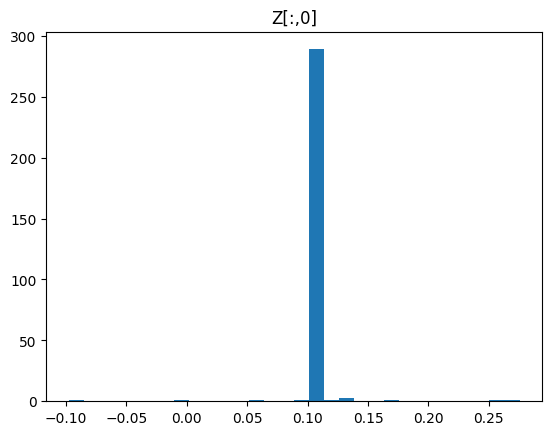

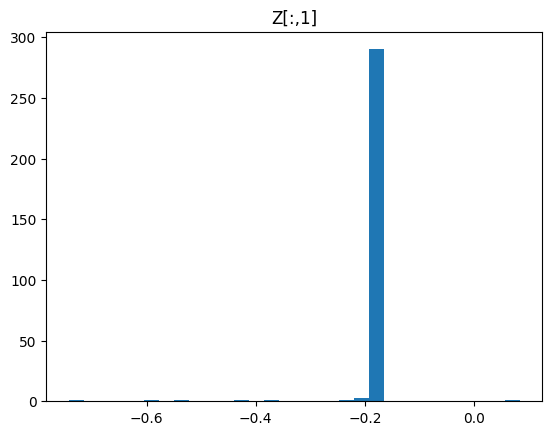

In [23]:
# encode entire slice
ae_s.eval()
Z = []
with torch.no_grad():
    for xb in DataLoader(ds_s, batch_size=128):
        xb = xb.to(device)
        z = ae_s.encode(xb)
        Z.append(z.cpu().numpy())
Z = np.concatenate(Z, axis=0)
plt.figure(); plt.hist(Z[:,0], bins=30); plt.title("Z[:,0]"); plt.show()
plt.figure(); plt.hist(Z[:,1], bins=30); plt.title("Z[:,1]"); plt.show()

### Q3 solution

In [24]:
vae.eval()
with torch.no_grad():
    samp = vae.sample(64, stoi_qm, itos_qm, max_len=max_len_qm, device=device)
valid = [is_valid_smiles(s) for s in samp]
print("Validity:", sum(valid), "/", len(samp))
print("First 10 valid:")
cnt = 0
for s in samp:
    if is_valid_smiles(s):
        print(s)
        cnt += 1
        if cnt >= 10:
            break

Validity: 64 / 64
First 10 valid:
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC
CCCC


### Q4 solution

In [25]:
a, b = qm_smiles[0], qm_smiles[1]
outs = interpolate(vae, a, b, stoi_qm, itos_qm, steps=8, device=device, max_len=max_len_qm)
val = [is_valid_smiles(s) for s in outs]
print("Valid steps:", sum(val), "/", len(outs))
for i,(s,ok) in enumerate(zip(outs, val)):
    print(f"{i}: {s}   valid={ok}")

Valid steps: 8 / 8
0: CCCC   valid=True
1: CCCC   valid=True
2: CCCC   valid=True
3: CCCC   valid=True
4: CCCC   valid=True
5: CCCC   valid=True
6: CCCC   valid=True
7: CCCC   valid=True


### Q5 solution

In [26]:
# encode all mus for nearest neighbor search
vae.eval()
M = []
with torch.no_grad():
    for xb in DataLoader(ds_vae, batch_size=256):
        xb = xb.to(device)
        mu = vae.encode(xb)
        M.append(mu.cpu().numpy())
Mu = np.concatenate(M, axis=0)  # [N, zdim]

# pick query
s_star = qm_smiles[10]
x_star = torch.from_numpy(encode_smiles(s_star, stoi_qm, max_len_qm)).unsqueeze(0).to(device)
with torch.no_grad():
    mu_star = vae.encode(x_star).cpu().numpy()[0]

# nearest neighbors
d = np.linalg.norm(Mu - mu_star, axis=1)
idx = np.argsort(d)[:5]
z_avg = Mu[idx].mean(axis=0)

# sample around z_avg
with torch.no_grad():
    z = torch.from_numpy(z_avg).float().unsqueeze(0).to(device)
    outs = []
    for _ in range(10):
        z_noisy = z + 0.1*torch.randn_like(z)
        cur = torch.full((1,1), stoi_qm["<bos>"], dtype=torch.long, device=device)
        h=None; seq=[]
        for _ in range(max_len_qm):
            emb = vae.emb(cur)
            zrep = z_noisy.unsqueeze(1)
            dec_cat = torch.cat([emb, zrep], dim=2)
            dec_out, h = vae.decoder(dec_cat, h)
            logits = vae.out(dec_out[:,-1,:])
            nxt = torch.argmax(logits, dim=-1, keepdim=True)
            seq.append(nxt); cur = nxt
        ids = torch.cat(seq, dim=1)
        outs.append(decode_ids(ids[0].cpu().numpy(), itos_qm))

ok = [is_valid_smiles(s) for s in outs]
print("Validity around z_avg:", sum(ok), "/", len(outs))
print("\nFive samples:")
for s in outs[:5]:
    print(s)

Validity around z_avg: 10 / 10

Five samples:
CCCC
CCCC
CCCC
CCCC
CCCC
